<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [141]:
import numpy as np

In [9]:
from tensorflow.keras.datasets import boston_housing

In [156]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [157]:
from sklearn.preprocessing import MinMaxScaler

# Scale training and test data
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [129]:
b_h_model = Sequential()

b_h_model.add(Dense(6, input_dim=13, activation='relu'))

b_h_model.add(Dense(6, activation='relu'))

b_h_model.add(Dense(6, activation='relu'))

b_h_model.add(Dense(1, activation='relu'))

b_h_model.compile(loss='mean_squared_error',
                  optimizer='adam')

b_h_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 6)                 84        
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_40 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 7         
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________


In [29]:
x_train.shape

(404, 13)

In [130]:
bh_hist = b_h_model.fit(x_train, y_train, epochs=500, validation_split=0, validation_data=(x_test, y_test), verbose=0)

In [47]:
hist.history.keys()

dict_keys(['loss', 'val_loss'])

In [50]:
import matplotlib.pyplot as plt

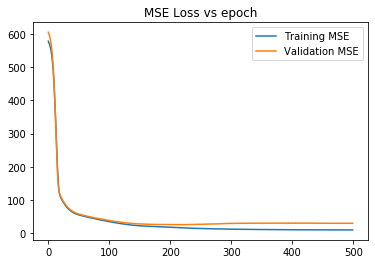

In [131]:
ys = bh_hist.history['loss']
xs = range(len(ys))
plt.plot(xs, ys, label='Training MSE')

ys = bh_hist.history['val_loss']
plt.plot(xs, ys, label='Validation MSE')


plt.legend(loc='upper right')

plt.title("MSE Loss vs epoch")
plt.show()

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [57]:
b_h_lr = LinearRegression()

In [58]:
b_h_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [65]:
print("Linear Regression Training MSE: ", mean_squared_error(b_h_lr.predict(x_train), y_train))
print("Neural Network Training MSE: ", mean_squared_error(b_h_model.predict(x_train), y_train))
print("Linear Regression Test MSE: ", mean_squared_error(b_h_lr.predict(x_test), y_test))
print("Neural Network Test MSE: ", mean_squared_error(b_h_model.predict(x_test), y_test))

Linear Regression Training MSE:  22.00480083834814
Neural Network Training MSE:  10.3877208407406
Linear Regression Test MSE:  23.19559925642294
Neural Network Test MSE:  30.429734792309524


Their performance is fairly similar, though it seems the neural network has over-fitted, slightly.

I have no idea what sort of feature engineering is expected. I decided to add an extra column corresponding to 10 nearest neigbors.

In [132]:
from sklearn.neighbors import KNeighborsRegressor 

In [133]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [158]:
x_train = np.append(x_train.T, [neigh.predict(x_train)], axis=0).T
x_test = np.append(x_test.T, [neigh.predict(x_test)], axis=0).T

In [164]:
b_h_model = Sequential()

b_h_model.add(Dense(6, input_dim=14, activation='relu'))

b_h_model.add(Dense(6, activation='relu'))

b_h_model.add(Dense(6, activation='relu'))

b_h_model.add(Dense(1, activation='relu'))

b_h_model.compile(loss='mean_squared_error',
                  optimizer='adam')

b_h_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 6)                 90        
_________________________________________________________________
dense_47 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_48 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 7         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [165]:
bh_hist = b_h_model.fit(x_train, y_train, epochs=500, validation_split=0, validation_data=(x_test, y_test), verbose=0)

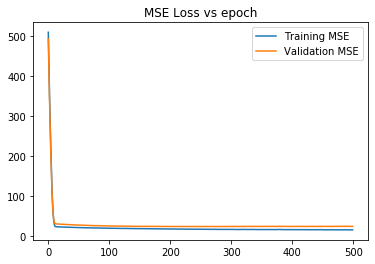

In [166]:
ys = bh_hist.history['loss']
xs = range(len(ys))
plt.plot(xs, ys, label='Training MSE')

ys = bh_hist.history['val_loss']
plt.plot(xs, ys, label='Validation MSE')


plt.legend(loc='upper right')

plt.title("MSE Loss vs epoch")
plt.show()

In [161]:
b_h_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [167]:
print("Linear Regression Training MSE: ", mean_squared_error(b_h_lr.predict(x_train), y_train))
print("Neural Network Training MSE: ", mean_squared_error(b_h_model.predict(x_train), y_train))
print("Linear Regression Test MSE: ", mean_squared_error(b_h_lr.predict(x_test), y_test))
print("Neural Network Test MSE: ", mean_squared_error(b_h_model.predict(x_test), y_test))

Linear Regression Training MSE:  15.55514716244064
Neural Network Training MSE:  15.76982611917567
Linear Regression Test MSE:  22.096426119375554
Neural Network Test MSE:  24.80017995540126


The regressor was able to improve on the training score, but not the test score. The Neural network, on the otherhand, improved both on the training and test scores.

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [113]:
from tensorflow.keras.datasets import fashion_mnist
import keras

(x_train_fm, y_train_fm), (x_test_fm, y_test_fm) = fashion_mnist.load_data()

# Normalize data
x_train_fm = x_train_fm / 255
x_test_fm = x_test_fm / 255

# Add dummy dimention to input
x_train_fm = x_train_fm.reshape(-1, 28, 28, 1)
x_test_fm = x_test_fm.reshape(-1, 28, 28, 1)

# make outputs categorical
y_train_fm = keras.utils.to_categorical(y_train_fm, 10)
y_test_fm = keras.utils.to_categorical(y_test_fm, 10)

Network description from Grenade documentation:

```
Network
    '[ Convolution 1 10 5 5 1 1, Pooling 2 2 2 2, Relu
     , Convolution 10 16 5 5 1 1, Pooling 2 2 2 2, FlattenLayer, Relu
     , FullyConnected 256 80, Logit, FullyConnected 80 10, Logit]
    '[ 'D2 28 28, 'D3 24 24 10, 'D3 12 12 10, 'D3 12 12 10
     , 'D3 8 8 16, 'D3 4 4 16, 'D1 256, 'D1 256
     , 'D1 80, 'D1 80, 'D1 10, 'D1 10]
```

In [105]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation

In [118]:
fm_model = Sequential()

fm_model.add(Conv2D(10, (5,5), input_shape=(28, 28, 1), strides=(1, 1)))

fm_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

fm_model.add(Activation('relu'))

fm_model.add(Conv2D(16, (5,5), strides=(1, 1)))

fm_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

fm_model.add(Flatten())

fm_model.add(Activation('relu'))

fm_model.add(Dense(256, activation='softmax'))

fm_model.add(Dense(80, activation='softmax'))

fm_model.add(Dense(10, activation='softmax'))

fm_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

fm_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 10)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 16)          4016      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 256)             

In [119]:
hist = fm_model.fit(x_train_fm, y_train_fm, epochs=30, validation_split=0, validation_data=(x_test_fm, y_test_fm))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 22s 363us/sample - loss: 1.8032 - accuracy: 0.4278 - val_loss: 1.2475 - val_accuracy: 0.4800
Epoch 2/30
60000/60000 [==============================] - 24s 401us/sample - loss: 1.0844 - accuracy: 0.5217 - val_loss: 1.0055 - val_accuracy: 0.5525
Epoch 3/30
60000/60000 [==============================] - 26s 438us/sample - loss: 0.8471 - accuracy: 0.7071 - val_loss: 0.7227 - val_accuracy: 0.7646
Epoch 4/30
60000/60000 [==============================] - 23s 381us/sample - loss: 0.6210 - accuracy: 0.7927 - val_loss: 0.5752 - val_accuracy: 0.7994
Epoch 5/30
60000/60000 [==============================] - 21s 348us/sample - loss: 0.5298 - accuracy: 0.8128 - val_loss: 0.5283 - val_accuracy: 0.8096
Epoch 6/30
60000/60000 [==============================] - 21s 355us/sample - loss: 0.4861 - accuracy: 0.8267 - val_loss: 0.5005 - val_accuracy: 0.8189
Epoch 7/30
60000/60000 [====================

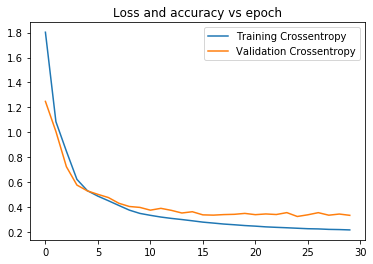

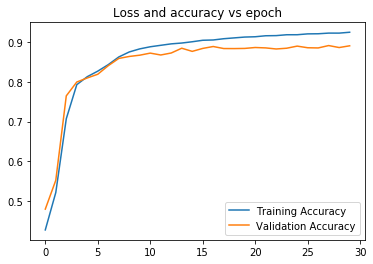

In [124]:
ys = hist.history['loss']
xs = range(len(xs))
plt.plot(xs, ys, label='Training Crossentropy')

ys = hist.history['val_loss']
plt.plot(xs, ys, label='Validation Crossentropy')

plt.legend(loc='upper right')

plt.title("Loss and accuracy vs epoch")
plt.show()


ys = hist.history['accuracy']
plt.plot(xs, ys, label='Training Accuracy')

ys = hist.history['val_accuracy']
plt.plot(xs, ys, label='Validation Accuracy')

plt.legend(loc='lower right')

plt.title("Loss and accuracy vs epoch")
plt.show()

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.